(-0.5, 255.5, 255.5, -0.5)

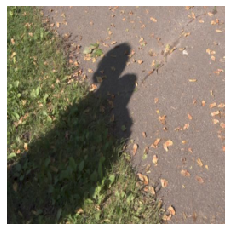

In [1]:
import cv2
import numpy as np
import math
import statistics
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import os
import scipy.stats
from ttictoc import tic,toc
from scipy.stats import entropy

img = cv2.imread('./shadow_input/18.png')
img_show = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_show)
plt.axis('off')

In [2]:
img = cv2.GaussianBlur(img,(3,3),0)
img = np.float64(img)
blue,green,red=cv2.split(img)
blue[blue==0]=1
green[green==0]=1
red[red==0]=1

div=np.multiply(np.multiply(blue,green),red)**(1.0/3)
b=np.log1p((blue/div)-1)
g=np.log1p((green/div)-1)
r=np.log1p((red/div)-1)

b1 = np.atleast_3d(b)
g1 = np.atleast_3d(g)
r1 = np.atleast_3d(r)
rho= np.concatenate((r1,g1,b1),axis=2) #log chromaticity on a plane, r, g, b

U=[[1/math.sqrt(2),-1/math.sqrt(2),0],[1/math.sqrt(6),1/math.sqrt(6),-2/math.sqrt(6)]]
U=np.array(U)                          #eigens

chi=np.dot(rho,U.T)                    #2D points on a plane orthogonal to [1,1,1]

e_t=np.zeros((2,181))
for j in range(181):
    e_t[0][j]=math.cos(j*math.pi/180.0)
    e_t[1][j]=math.sin(j*math.pi/180.0)

Entropy Minimization (see Fig.3)

In [3]:
def normfit(data, confidence=0.9):
        a = 1.0 * np.array(data)
        n = len(a)
        m, se = np.mean(a), scipy.stats.sem(a)
        h = se * scipy.stats.t.ppf((1 + confidence) / 2., n - 1)
        var = np.var(data, ddof=1)
        varCI_upper = var * (n - 1) / (scipy.stats.chi2.ppf((1-confidence) / 2, n - 1))
        varCI_lower = var * (n - 1) / (scipy.stats.chi2.ppf(1-(1-confidence) / 2, n - 1))
        sigma = np.sqrt(var)
        sigmaCI_lower = np.sqrt(varCI_lower)
        sigmaCI_upper = np.sqrt(varCI_upper)
        return m, sigma, [m - h, m + h], [sigmaCI_lower, sigmaCI_upper]
Y=np.dot(chi,e_t)
nel=img.shape[0]*img.shape[1]
entropy=[]
bw=np.zeros((1,181))
for i in range(181):
    muhat, sigma, muci, sigmaci = normfit(Y[:,:,i])                                  #we take only 90% of the median data, noise, projected data 
    temp=[]
    comp1=muhat-sigmaci[0]                                                           #mean, std 
    comp2=muhat+sigmaci[1]
    for j in range(Y.shape[0]):
        for k in range(Y.shape[1]):
            if Y[j][k][i]>comp1 and Y[j][k][i]<comp2:
                temp.append(Y[j][k][i])
    #histogram counting
    bw[0][i]=(3.5*np.std(temp))*((nel)**(-1.0/3))
    nbins=np.int(math.ceil((max(temp)-min(temp))/bw[0][i]))
    (hist,waste)=np.histogram(temp,bins=nbins,density=True)

    hist=filter(lambda var1: var1 != 0, hist)
    hist1=np.array([float(var) for var in hist])
    hist1=hist1/sum(hist1)
    entropy.append(-1*sum(np.multiply(hist1,np.log2(hist1))))
angle=entropy.index(min(entropy))
print('angle',angle)

angle 150


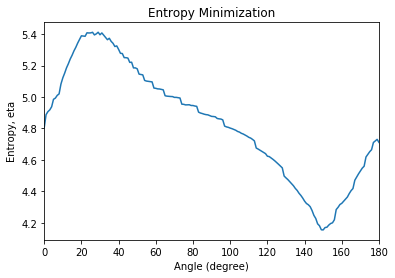

In [4]:
eta = np.array([entropy[p] for p in range(181)])
plt.clf()
plt.plot(eta)
plt.xlabel('Angle (degree)')
plt.ylabel('Entropy, eta')
plt.xlim(0, 180)
plt.title('Entropy Minimization')
plt.show()

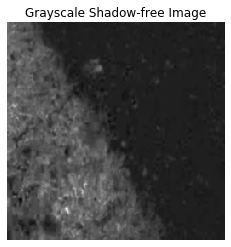

In [5]:
e=np.array([[-1*math.sin(angle*math.pi/180.0)],
            [math.cos(angle*math.pi/180.0)]])
e_t=np.array([[math.cos(angle*math.pi/180.0)],
              [math.sin(angle*math.pi/180.0)]])

gs_approx = chi.dot(e_t)
# Grayscale Shadow-free (see Fig.5(b), no shadow)
plt.clf()
plt.imshow(gs_approx.squeeze(), cmap='gray')
plt.axis('off')
plt.title('Grayscale Shadow-free Image')
plt.show()

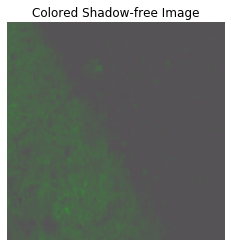

In [6]:
P_theta = np.ma.divide(np.dot(e_t, e_t.T), np.linalg.norm(e))
chi_theta = chi.dot(P_theta)

#3-D log ratio
rho_estim = chi_theta.dot(U)
#Invariant chromaticity image
mean_estim = np.ma.exp(rho_estim)                                                   
estim = np.zeros_like(mean_estim, dtype=np.float64)
estim[:,:,0] = np.divide(mean_estim[:,:,0], np.sum(mean_estim, axis=2))
estim[:,:,1] = np.divide(mean_estim[:,:,1], np.sum(mean_estim, axis=2))
estim[:,:,2] = np.divide(mean_estim[:,:,2], np.sum(mean_estim, axis=2))

# Colored Shadow-free (see Fig.5(c), no shadow)
plt.imshow(estim)
plt.axis('off')
plt.title('Colored Shadow-free Image')
plt.show()